In [20]:
import numpy as np

from sklearn.decomposition import KernelPCA,PCA
from gtda.time_series import TakensEmbedding,SingleTakensEmbedding
from gtda.time_series import Resampler, SlidingWindow, takens_embedding_optimal_parameters, \
    TakensEmbedding, PermutationEntropy, SingleTakensEmbedding
from gtda.homology import WeakAlphaPersistence, VietorisRipsPersistence
from gtda.diagrams import Scaler, Filtering, PersistenceEntropy, BettiCurve, PairwiseDistance, Amplitude
from scipy.signal import resample
from sklearn.preprocessing import StandardScaler


eegs=np.load('EEG_all.npy',allow_pickle=True).item()


In [21]:

def process_eegs(key,eegs,time_delay=20, dimension=20):
    
    scaler = StandardScaler()
    eegs=scaler.fit_transform(eegs)

    if(len(eegs[0]) < time_delay * dimension): return {'dg':[],'pe':[],'amp':[]}
    
    with open('logfile.log', 'a') as f: f.write(f'{key}\n')

    homology_dimensions = [0,1,2]

    VR = VietorisRipsPersistence(
        metric="euclidean",
        homology_dimensions=homology_dimensions,
        n_jobs=-1,
        collapse_edges=True,
    )

    entropy = PersistenceEntropy(normalize=True, nan_fill_value=np.nan)
    amplitude=Amplitude(metric='wasserstein')
    stride = 5


    TE = TakensEmbedding(time_delay=time_delay, dimension=dimension, stride=stride)
    ye=TE.fit_transform(eegs)

    dg=VR.fit_transform(ye)
    pe=entropy.fit_transform(dg)
    amp=amplitude.fit_transform(dg)
    return {'dg':dg,'pe':pe,'amp':amp}


In [22]:
cbt_eeg_list_tp=[]
cbt_eeg_list_af=[]

for eeg in eegs['SLR']:
    data_tp=0.5*(eeg[:,0]+eeg[:,3])
    data_af=0.5*(eeg[:,1]+eeg[:,2])
    cbt_eeg_list_tp.append(resample(data_tp,64*25))
    cbt_eeg_list_af.append(resample(data_af,64*25))

cbt_tda_af=process_eegs("af",cbt_eeg_list_af,time_delay=20, dimension=20)
np.save('SLR_tda_af',cbt_tda_af)

cbt_tda_tp=process_eegs("tp",cbt_eeg_list_tp,time_delay=20, dimension=20)
np.save('SLR_tda_tp',cbt_tda_tp)

In [23]:
recall_eeg_list_tp=[]
recall_eeg_list_af=[]

for eeg in eegs['SCR']:
    data_tp=0.5*(eeg[:,0]+eeg[:,3])
    data_af=0.5*(eeg[:,1]+eeg[:,2])
    recall_eeg_list_tp.append(resample(data_tp,64*25))
    recall_eeg_list_af.append(resample(data_af,64*25))

recall_tda_af=process_eegs("af",recall_eeg_list_af,time_delay=20, dimension=20)
np.save('SCR_tda_af',recall_tda_af)

recall_tda_tp=process_eegs("tp",recall_eeg_list_tp,time_delay=20, dimension=20)
np.save('SCR_tda_tp',recall_tda_tp)



In [24]:
ctr_eeg_list_tp=[]
ctr_eeg_list_af=[]
subs_ctr=[]
for eeg in eegs['CTR']:
    data_tp=0.5*(eeg[:,0]+eeg[:,3])
    data_af=0.5*(eeg[:,1]+eeg[:,2])
    ctr_eeg_list_tp.append(resample(data_tp,64*25))
    ctr_eeg_list_af.append(resample(data_af,64*25))

ctr_eeg_list_af=np.asarray(ctr_eeg_list_af)
ctr_eeg_list_tp=np.asarray(ctr_eeg_list_tp)

ctr_tda_af=process_eegs("af",ctr_eeg_list_af,time_delay=20, dimension=20)
np.save('CTR_tda_af',ctr_tda_af)

ctr_tda_tp=process_eegs("tp",ctr_eeg_list_tp,time_delay=20, dimension=20)
np.save('CTR_tda_tp',ctr_tda_tp)

In [25]:
def get_betti_areas(diagrams):
    BC = BettiCurve(n_bins=100)
    bcs= BC.fit_transform(diagrams)
    X = BC.samplings_
    ba_sw =[] # all sliding windows
    i = 0
    for bc in bcs:
        i = i +1
        temp_areas=[]

        for bci,bc_hg in enumerate(bc):
            temp_areas.append(np.trapz(bc_hg,X[bci]))
        ba_sw.append(temp_areas)
    
    return ba_sw



In [26]:
import pandas as  pd

A0_af=cbt_tda_af['amp'][:,0]
A1_af=cbt_tda_af['amp'][:,1]
A2_af=cbt_tda_af['amp'][:,2]

PE0_af=cbt_tda_af['pe'][:,0]
PE1_af=cbt_tda_af['pe'][:,1]
PE2_af=cbt_tda_af['pe'][:,2]

A0_af=cbt_tda_af['amp'][:,0]
A1_af=cbt_tda_af['amp'][:,1]
A2_af=cbt_tda_af['amp'][:,2]

BA_af=np.asarray(get_betti_areas(cbt_tda_af['dg']))
BA0_af=BA_af[:,0]
BA1_af=BA_af[:,1]
BA2_af=BA_af[:,2]


A0_tp=cbt_tda_tp['amp'][:,0]
A1_tp=cbt_tda_tp['amp'][:,1]
A2_tp=cbt_tda_tp['amp'][:,2]

PE0_tp=cbt_tda_tp['pe'][:,0]
PE1_tp=cbt_tda_tp['pe'][:,1]
PE2_tp=cbt_tda_tp['pe'][:,2]

A0_tp=cbt_tda_tp['amp'][:,0]
A1_tp=cbt_tda_tp['amp'][:,1]
A2_tp=cbt_tda_tp['amp'][:,2]

BA_tp=np.asarray(get_betti_areas(cbt_tda_tp['dg']))
BA0_tp=BA_tp[:,0]
BA1_tp=BA_tp[:,1]
BA2_tp=BA_tp[:,2]


arr_cbt=[A0_tp,A1_tp,A2_tp,A0_af,A1_af,A2_af,
        PE0_tp,PE1_tp,PE2_tp,PE0_af,PE1_af,PE2_af]

columns=['A0_tp','A1_tp','A2_tp','A0_af','A1_af','A2_af',
        'PE0_tp','PE1_tp','PE2_tp','PE0_af','PE1_af','PE2_af']

df_cbt=pd.DataFrame(np.asarray(arr_cbt).T,columns=columns)

In [27]:
import pandas as  pd


A0_af=ctr_tda_af['amp'][:,0]
A1_af=ctr_tda_af['amp'][:,1]
A2_af=ctr_tda_af['amp'][:,2]

PE0_af=ctr_tda_af['pe'][:,0]
PE1_af=ctr_tda_af['pe'][:,1]
PE2_af=ctr_tda_af['pe'][:,2]


A0_tp=ctr_tda_tp['amp'][:,0]
A1_tp=ctr_tda_tp['amp'][:,1]
A2_tp=ctr_tda_tp['amp'][:,2]

PE0_tp=ctr_tda_tp['pe'][:,0]
PE1_tp=ctr_tda_tp['pe'][:,1]
PE2_tp=ctr_tda_tp['pe'][:,2]


arr_ctr=[A0_tp,A1_tp,A2_tp,A0_af,A1_af,A2_af,
        PE0_tp,PE1_tp,PE2_tp,PE0_af,PE1_af,PE2_af]

columns=['A0_tp','A1_tp','A2_tp','A0_af','A1_af','A2_af',
        'PE0_tp','PE1_tp','PE2_tp','PE0_af','PE1_af','PE2_af']

df_ctr=pd.DataFrame(np.asarray(arr_ctr).T,columns=columns)

In [28]:
import pandas as  pd


A0_af=recall_tda_af['amp'][:,0]
A1_af=recall_tda_af['amp'][:,1]
A2_af=recall_tda_af['amp'][:,2]

PE0_af=recall_tda_af['pe'][:,0]
PE1_af=recall_tda_af['pe'][:,1]
PE2_af=recall_tda_af['pe'][:,2]


A0_tp=recall_tda_tp['amp'][:,0]
A1_tp=recall_tda_tp['amp'][:,1]
A2_tp=recall_tda_tp['amp'][:,2]

PE0_tp=recall_tda_tp['pe'][:,0]
PE1_tp=recall_tda_tp['pe'][:,1]
PE2_tp=recall_tda_tp['pe'][:,2]


arr_recall=[A0_tp,A1_tp,A2_tp,A0_af,A1_af,A2_af,
        PE0_tp,PE1_tp,PE2_tp,PE0_af,PE1_af,PE2_af]

columns=['A0_tp','A1_tp','A2_tp','A0_af','A1_af','A2_af',
        'PE0_tp','PE1_tp','PE2_tp','PE0_af','PE1_af','PE2_af']

df_recall=pd.DataFrame(np.asarray(arr_recall).T,columns=columns)

In [29]:
BC=BettiCurve()

BC_ctr_af=BC.fit_transform(ctr_tda_af['dg'])
x_ctr_af=BC._samplings

BC_ctr_tp=BC.fit_transform(ctr_tda_tp['dg'])
x_ctr_tp=BC._samplings

BC_recall_af=BC.fit_transform(recall_tda_af['dg'])
x_recall_af=BC._samplings

BC_recall_tp=BC.fit_transform(recall_tda_tp['dg'])
x_recall_tp=BC._samplings


BC_cbt_af=BC.fit_transform(cbt_tda_af['dg'])
x_cbt_af=BC._samplings

BC_cbt_tp=BC.fit_transform(cbt_tda_tp['dg'])
x_cbt_tp=BC._samplings




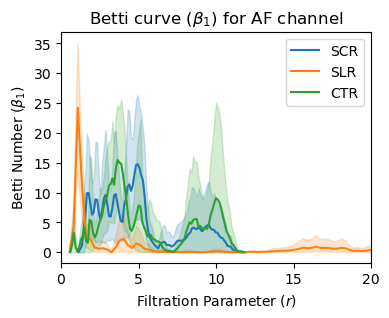

In [39]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(4, 3))
#======================================

data = BC_recall_af[:,1,:]
x = x_recall_af[1][:,0,0]
df = pd.DataFrame(data.T, columns=[f'Sample {i+1}' for i in range(data.shape[0])])
df['x'] = x
df_melted = df.melt(id_vars='x', var_name='Sample', value_name='Value')
sns.lineplot(x='x', y='Value', data=df_melted, errorbar=('ci', 95),label='SCR')

data = BC_cbt_af[:,1,:]
x = x_cbt_af[1][:,0,0]
df = pd.DataFrame(data.T, columns=[f'Sample {i+1}' for i in range(data.shape[0])])
df['x'] = x
df_melted = df.melt(id_vars='x', var_name='Sample', value_name='Value')
sns.lineplot(x='x', y='Value', data=df_melted, errorbar=('ci', 95),label='SLR')

data = BC_ctr_af[:,1,:]
x = x_ctr_af[1][:,0,0]
df = pd.DataFrame(data.T, columns=[f'Sample {i+1}' for i in range(data.shape[0])])
df['x'] = x
df_melted = df.melt(id_vars='x', var_name='Sample', value_name='Value')
sns.lineplot(x='x', y='Value', data=df_melted, errorbar=('ci', 95),label='CTR')


# plt.legend(['SCR','SLR','CTR'])
# plt.yscale('log')
plt.title(r'Betti curve ($\beta_1$) for AF channel')
plt.xlabel(r'Filtration Parameter ($r$)')
plt.ylabel(r'Betti Number ($\beta_1$)')
plt.xlim([0,20])
# plt.tight_layout()
# plt.savefig('bc1_af.pdf',format='pdf')  # Save with high resolution

plt.show()



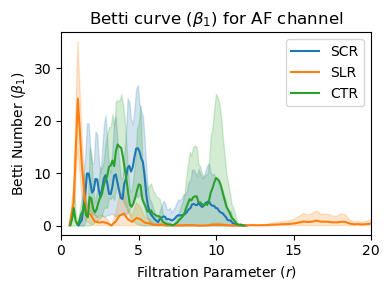

In [40]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(4, 3))
#======================================

data = BC_recall_af[:,1,:]
x = x_recall_af[1][:,0,0]
df = pd.DataFrame(data.T, columns=[f'Sample {i+1}' for i in range(data.shape[0])])
df['x'] = x
df_melted = df.melt(id_vars='x', var_name='Sample', value_name='Value')
sns.lineplot(x='x', y='Value', data=df_melted, errorbar=('ci', 95),label='SCR')

data = BC_cbt_af[:,1,:]
x = x_cbt_af[1][:,0,0]
df = pd.DataFrame(data.T, columns=[f'Sample {i+1}' for i in range(data.shape[0])])
df['x'] = x
df_melted = df.melt(id_vars='x', var_name='Sample', value_name='Value')
sns.lineplot(x='x', y='Value', data=df_melted, errorbar=('ci', 95),label='SLR')

data = BC_ctr_af[:,1,:]
x = x_ctr_af[1][:,0,0]
df = pd.DataFrame(data.T, columns=[f'Sample {i+1}' for i in range(data.shape[0])])
df['x'] = x
df_melted = df.melt(id_vars='x', var_name='Sample', value_name='Value')
sns.lineplot(x='x', y='Value', data=df_melted, errorbar=('ci', 95),label='CTR')


# plt.legend(['SCR','SLR','CTR'])
# plt.yscale('log')
plt.title(r'Betti curve ($\beta_1$) for AF channel')
plt.xlabel(r'Filtration Parameter ($r$)')
plt.ylabel(r'Betti Number ($\beta_1$)')
plt.xlim([0,20])

plt.tight_layout()
plt.savefig('bc1_af.pdf',format='pdf')  # Save with high resolution

plt.show()



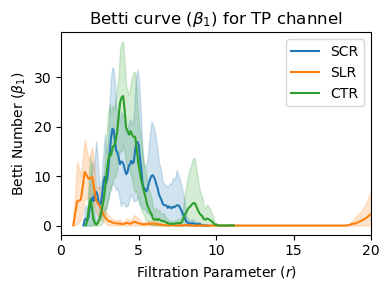

In [41]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(4, 3))
#======================================

data = BC_recall_tp[:,1,:]
x = x_recall_tp[1][:,0,0]
df = pd.DataFrame(data.T, columns=[f'Sample {i+1}' for i in range(data.shape[0])])
df['x'] = x
df_melted = df.melt(id_vars='x', var_name='Sample', value_name='Value')
sns.lineplot(x='x', y='Value', data=df_melted, errorbar=('ci', 95),label='SCR')

data = BC_cbt_tp[:,1,:]
x = x_cbt_tp[1][:,0,0]
df = pd.DataFrame(data.T, columns=[f'Sample {i+1}' for i in range(data.shape[0])])
df['x'] = x
df_melted = df.melt(id_vars='x', var_name='Sample', value_name='Value')
sns.lineplot(x='x', y='Value', data=df_melted, errorbar=('ci', 95),label='SLR')

data = BC_ctr_tp[:,1,:]
x = x_ctr_tp[1][:,0,0]
df = pd.DataFrame(data.T, columns=[f'Sample {i+1}' for i in range(data.shape[0])])
df['x'] = x
df_melted = df.melt(id_vars='x', var_name='Sample', value_name='Value')
sns.lineplot(x='x', y='Value', data=df_melted, errorbar=('ci', 95),label='CTR')


# plt.legend(['SCR','SLR','CTR'])
# plt.yscale('log')
plt.title(r'Betti curve ($\beta_1$) for TP channel')
plt.xlabel(r'Filtration Parameter ($r$)')
plt.ylabel(r'Betti Number ($\beta_1$)')
plt.xlim([0,20])

plt.tight_layout()
plt.savefig('bc1_tp.pdf',format='pdf')  # Save with high resolution

plt.show()



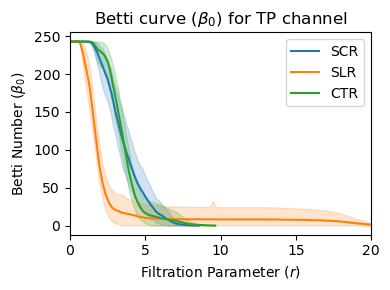

In [42]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(4, 3))
#======================================

data = BC_recall_tp[:,0,:]
x = x_recall_tp[0][:,0,0]
df = pd.DataFrame(data.T, columns=[f'Sample {i+1}' for i in range(data.shape[0])])
df['x'] = x
df_melted = df.melt(id_vars='x', var_name='Sample', value_name='Value')
sns.lineplot(x='x', y='Value', data=df_melted, errorbar=('ci', 95),label='SCR')

data = BC_cbt_tp[:,0,:]
x = x_cbt_tp[0][:,0,0]
df = pd.DataFrame(data.T, columns=[f'Sample {i+1}' for i in range(data.shape[0])])
df['x'] = x
df_melted = df.melt(id_vars='x', var_name='Sample', value_name='Value')
sns.lineplot(x='x', y='Value', data=df_melted, errorbar=('ci', 95),label='SLR')

data = BC_ctr_tp[:,0,:]
x = x_ctr_tp[0][:,0,0]
df = pd.DataFrame(data.T, columns=[f'Sample {i+1}' for i in range(data.shape[0])])
df['x'] = x
df_melted = df.melt(id_vars='x', var_name='Sample', value_name='Value')
sns.lineplot(x='x', y='Value', data=df_melted, errorbar=('ci', 95),label='CTR')


# plt.legend(['SCR','SLR','CTR'])
# plt.yscale('log')
plt.title(r'Betti curve ($\beta_0$) for TP channel')
plt.xlabel(r'Filtration Parameter ($r$)')
plt.ylabel(r'Betti Number ($\beta_0$)')
plt.xlim([0,20])

plt.tight_layout()
plt.savefig('bc0_tp.pdf',format='pdf')  # Save with high resolution

plt.show()

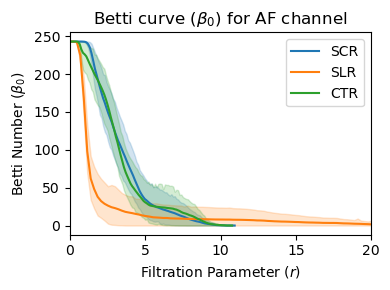

In [43]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(4, 3))
#======================================

data = BC_recall_af[:,0,:]
x = x_recall_af[0][:,0,0]
df = pd.DataFrame(data.T, columns=[f'Sample {i+1}' for i in range(data.shape[0])])
df['x'] = x
df_melted = df.melt(id_vars='x', var_name='Sample', value_name='Value')
sns.lineplot(x='x', y='Value', data=df_melted, errorbar=('ci', 95),label='SCR')

data = BC_cbt_af[:,0,:]
x = x_cbt_af[0][:,0,0]
df = pd.DataFrame(data.T, columns=[f'Sample {i+1}' for i in range(data.shape[0])])
df['x'] = x
df_melted = df.melt(id_vars='x', var_name='Sample', value_name='Value')
sns.lineplot(x='x', y='Value', data=df_melted, errorbar=('ci', 95),label='SLR')

data = BC_ctr_af[:,0,:]
x = x_ctr_af[0][:,0,0]
df = pd.DataFrame(data.T, columns=[f'Sample {i+1}' for i in range(data.shape[0])])
df['x'] = x
df_melted = df.melt(id_vars='x', var_name='Sample', value_name='Value')
sns.lineplot(x='x', y='Value', data=df_melted, errorbar=('ci', 95),label='CTR')


# plt.legend(['SCR','SLR','CTR'])
# plt.yscale('log')
plt.title(r'Betti curve ($\beta_0$) for AF channel')
plt.xlabel(r'Filtration Parameter ($r$)')
plt.ylabel(r'Betti Number ($\beta_0$)')
plt.xlim([0,20])

plt.tight_layout()
plt.savefig('bc0_af.pdf',format='pdf')  # Save with high resolution

plt.show()

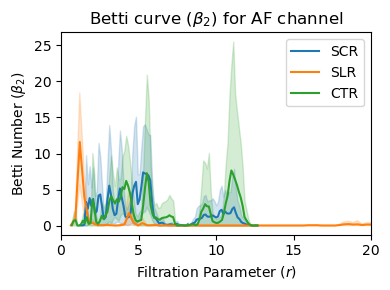

In [44]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(4, 3))
#======================================

data = BC_recall_af[:,2,:]
x = x_recall_af[2][:,0,0]
df = pd.DataFrame(data.T, columns=[f'Sample {i+1}' for i in range(data.shape[0])])
df['x'] = x
df_melted = df.melt(id_vars='x', var_name='Sample', value_name='Value')
sns.lineplot(x='x', y='Value', data=df_melted, errorbar=('ci', 95),label='SCR')

data = BC_cbt_af[:,2,:]
x = x_cbt_af[2][:,0,0]
df = pd.DataFrame(data.T, columns=[f'Sample {i+1}' for i in range(data.shape[0])])
df['x'] = x
df_melted = df.melt(id_vars='x', var_name='Sample', value_name='Value')
sns.lineplot(x='x', y='Value', data=df_melted, errorbar=('ci', 95),label='SLR')

data = BC_ctr_af[:,2,:]
x = x_ctr_af[2][:,0,0]
df = pd.DataFrame(data.T, columns=[f'Sample {i+1}' for i in range(data.shape[0])])
df['x'] = x
df_melted = df.melt(id_vars='x', var_name='Sample', value_name='Value')
sns.lineplot(x='x', y='Value', data=df_melted, errorbar=('ci', 95),label='CTR')


# plt.legend(['SCR','SLR','CTR'])
# plt.yscale('log')
plt.title(r'Betti curve ($\beta_2$) for AF channel')
plt.xlabel(r'Filtration Parameter ($r$)')
plt.ylabel(r'Betti Number ($\beta_2$)')
plt.xlim([0,20])

plt.tight_layout()
plt.savefig('bc2_af.pdf',format='pdf')  # Save with high resolution

plt.show()

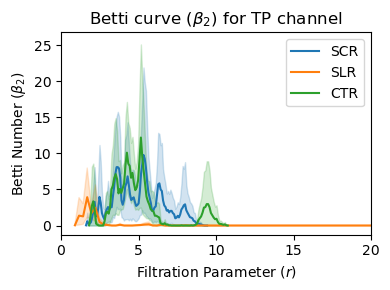

In [45]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(4, 3))
#======================================

data = BC_recall_tp[:,2,:]
x = x_recall_tp[2][:,0,0]
df = pd.DataFrame(data.T, columns=[f'Sample {i+1}' for i in range(data.shape[0])])
df['x'] = x
df_melted = df.melt(id_vars='x', var_name='Sample', value_name='Value')
sns.lineplot(x='x', y='Value', data=df_melted, errorbar=('ci', 95),label='SCR')

data = BC_cbt_tp[:,2,:]
x = x_cbt_tp[2][:,0,0]
df = pd.DataFrame(data.T, columns=[f'Sample {i+1}' for i in range(data.shape[0])])
df['x'] = x
df_melted = df.melt(id_vars='x', var_name='Sample', value_name='Value')
sns.lineplot(x='x', y='Value', data=df_melted, errorbar=('ci', 95),label='SLR')

data = BC_ctr_tp[:,2,:]
x = x_ctr_tp[2][:,0,0]
df = pd.DataFrame(data.T, columns=[f'Sample {i+1}' for i in range(data.shape[0])])
df['x'] = x
df_melted = df.melt(id_vars='x', var_name='Sample', value_name='Value')
sns.lineplot(x='x', y='Value', data=df_melted, errorbar=('ci', 95),label='CTR')


# plt.legend(['SCR','SLR','CTR'])
# plt.yscale('log')
plt.title(r'Betti curve ($\beta_2$) for TP channel')
plt.xlabel(r'Filtration Parameter ($r$)')
plt.ylabel(r'Betti Number ($\beta_2$)')
plt.xlim([0,20])

plt.tight_layout()
plt.savefig('bc2_tp.pdf',format='pdf')  # Save with high resolution

plt.show()

In [37]:
import scipy.stats as stats

# Perform Kruskal-Wallis test for each column
columns = df_recall.columns  # Assuming all dataframes have the same column names

kruskal_results = {}

for col in columns:
    stat, p_value = stats.kruskal(df_cbt[col].dropna(), df_recall[col].dropna(), df_ctr[col].dropna())
    kruskal_results[col] = {'statistic': stat, 'p_value': p_value}

# Display the results
for col, result in kruskal_results.items():
    print(f"Kruskal-Wallis Test for {col}:")
    print(f"Statistic: {result['statistic']}, P-value: {result['p_value']}\n")


Kruskal-Wallis Test for A0_tp:
Statistic: 36.22630681692385, P-value: 1.3600579858458974e-08

Kruskal-Wallis Test for A1_tp:
Statistic: 46.08434264322767, P-value: 9.838120643617394e-11

Kruskal-Wallis Test for A2_tp:
Statistic: 45.20543796724746, P-value: 1.5267357298331012e-10

Kruskal-Wallis Test for A0_af:
Statistic: 32.0750728776909, P-value: 1.0838930243382782e-07

Kruskal-Wallis Test for A1_af:
Statistic: 29.350138467612737, P-value: 4.233488751824555e-07

Kruskal-Wallis Test for A2_af:
Statistic: 22.72526992420717, P-value: 1.1621718079358175e-05

Kruskal-Wallis Test for PE0_tp:
Statistic: 36.02875117157811, P-value: 1.5012606044940263e-08

Kruskal-Wallis Test for PE1_tp:
Statistic: 45.20366676260687, P-value: 1.5280884094176024e-10

Kruskal-Wallis Test for PE2_tp:
Statistic: 5.859694854650513, P-value: 0.053405185695661245

Kruskal-Wallis Test for PE0_af:
Statistic: 32.0750728776909, P-value: 1.0838930243382782e-07

Kruskal-Wallis Test for PE1_af:
Statistic: 28.670451140581974

In [47]:
columns = df_recall.columns  # Assuming all dataframes have the same column names

mean_results = {}

for col in columns:
    mean_results[col] = [
                            np.round(df_recall[col].dropna().mean(),2), 
                            np.round(df_cbt[col].dropna().mean(),2),
                            np.round(df_ctr[col].dropna().mean(),2)]

mean_results

{'A0_tp': [28.32, 18.62, 28.18],
 'A1_tp': [2.01, 1.18, 2.0],
 'A2_tp': [0.89, 0.61, 0.86],
 'A0_af': [26.82, 14.7, 26.17],
 'A1_af': [1.83, 1.19, 1.85],
 'A2_af': [0.81, 0.5, 0.82],
 'PE0_tp': [0.82, 0.9, 0.82],
 'PE1_tp': [1.39, 1.88, 1.38],
 'PE2_tp': [1.89, -4.36, 1.84],
 'PE0_af': [0.84, 0.96, 0.85],
 'PE1_af': [1.46, 1.91, 1.53],
 'PE2_af': [2.31, 3.49, 2.04]}